# SM108 silencing RL Modelling

In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy.stats as stats

from flyjax.experiment.get import fetch_behavioral_data, get_experiments
from flyjax.utils.plotting import plot_single_experiment_data

import seaborn as sns
sns.set(style='ticks')
sns.set_palette('colorblind')
plt.rcParams['font.sans-serif'] = 'Arial'

def significance_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

expt_data_folder = '../../../data/SMP108-kir/dmVS_12-08-2024_expt/'
ctrl_data_folder = '../../../data/SMP108-kir/dmVS_12-08-2024_ctrl/'
processed_folder = 'processed_data' # folder containing the processed data
minimal_trials = 180 # minimal number of trials to consider a fly to be included in the analysis

expt_choices, expt_rewards, expt_metadata = fetch_behavioral_data(expt_data_folder, minimal_trials, remove_control=True)
n_experiments = len(expt_metadata)

ctrl_choices, ctrl_rewards, ctrl_metadata = fetch_behavioral_data(ctrl_data_folder, minimal_trials, remove_control=False)
n_controls = len(ctrl_metadata)

# set the seed for reproducibility
np.random.seed(0)

In [13]:
print(f'Number of experiments: {n_experiments}')
print(f'Number of controls: {n_controls}')

Number of experiments: 247
Number of controls: 299


## Fitting the best joint model (DFQ with Dynamic Exploration) to the experimental and control data

In [14]:
# fitting a joint model to the data
from flyjax.fitting.cv import parallel_k_fold_cross_validation_train_joint
from flyjax.agent.rl.zoo import dfq_agent_with_dynamic_exploration
from flyjax.fitting.samplers import base_randn_sampler
from functools import partial

In [15]:
experiments = [(expt_choices[i], expt_rewards[i]) for i in range(n_experiments)]
controls = [(ctrl_choices[i], ctrl_rewards[i]) for i in range(n_controls)]

In [ ]:
init_theta_sampler = partial(base_randn_sampler, mean=0.0, std=1.0, n_params=7)
init_delta_sampler = partial(base_randn_sampler, mean=0.0, std=0.1, n_params=7)

total_pred_ll, per_experiment_ll, params = parallel_k_fold_cross_validation_train_joint(
    experiments_control=controls,
    experiments_treatment=experiments,
    k=5,
    n_params=7,
    init_theta_sampler=init_theta_sampler,
    init_delta_sampler=init_delta_sampler,
    agent=dfq_agent_with_dynamic_exploration,
    learning_rate=5e-2,
    num_steps=10000,
    n_restarts=10,
    min_num_converged=3,
    early_stopping={"min_delta": 1e-4}
)

# make a nested dictionary with the results
results = {
    'total_log_likelihood': total_pred_ll,
    'subject_log_likelihood': per_experiment_ll,
    'fold_params': params
}
# save the results as a pickle file
results_file = os.path.join(processed_folder, 'dfq_dynamic_exploration_results.pkl')
with open(results_file, 'wb') as f:
    pickle.dump(results, f)


--- Joint Restart 1/10 ---

--- Joint Restart 1/10 ---

--- Joint Restart 1/10 ---

--- Joint Restart 1/10 ---

--- Joint Restart 1/10 ---


2025-02-20 22:39:49.902785: E external/xla/xla/service/slow_operation_alarm.cc:73] 
********************************
[Compiling module jit_step_fn] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2025-02-20 22:39:53.364230: E external/xla/xla/service/slow_operation_alarm.cc:73] 
********************************
[Compiling module jit_step_fn] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2025-02-20 22:39:53.421999: E external/xla/xla/service/slow_operation_alarm.cc:73] 
********************************
[Compiling module jit_step_fn] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2025-02-20 22:39:53.520094: E external/xla/xla/service/slow_operation_alarm.cc:73] 
****************

Restart 1 final Joint NLL: 168297.0625

--- Joint Restart 2/10 ---
Restart 1 final Joint NLL: 169296.9062

--- Joint Restart 2/10 ---
Restart 1 final Joint NLL: 166600.1875

--- Joint Restart 2/10 ---
Restart 1 final Joint NLL: 168321.2500

--- Joint Restart 2/10 ---
Restart 1 final Joint NLL: 169742.5938

--- Joint Restart 2/10 ---


In [ ]:
# load the results
results_file = os.path.join(processed_folder, 'dfq_dynamic_exploration_results.pkl')
with open(results_file, 'rb') as f:
    results = pickle.load(f)
total_pred_ll = results['total_log_likelihood']
per_experiment_ll = results['subject_log_likelihood']
params = results['fold_params']
params = np.array([params[i] for i in range(5)])
params = np.cumsum(params, axis=1)
# apply sigmoid on the first two parameters
params[:, :, :2] = 1 / (1 + np.exp(-params[:, :, :2]))
param_names = ['alpha_learn', 'alpha_forget', 'kappa_reward', 'kappa_omission', 'alpha_reward', 'epsilon_weight', 'epsilon_bias']


In [ ]:
params

array([[[ 0.29398987,  0.01837164,  5.967759  ,  5.38436   ,
         -1.911994  , -8.420963  ,  0.28073695],
        [ 0.24728881,  0.01316945,  6.561615  ,  5.9029284 ,
         -1.7616242 , -9.291156  ,  0.76028395]],

       [[ 0.02942135,  0.321055  ,  6.0879374 ,  1.9711875 ,
         -0.3252523 , -4.8934274 , -1.8967832 ],
        [ 0.02141553,  0.30173406,  6.986965  ,  2.4927306 ,
         -0.5558166 , -5.214721  , -1.2875867 ]],

       [[ 0.02843244,  0.32778624,  6.2674117 ,  1.9301946 ,
         -0.575975  , -5.5270305 , -1.6425154 ],
        [ 0.02102341,  0.2925608 ,  6.832855  ,  2.6896453 ,
         -0.2822144 , -5.722387  , -1.2851657 ]],

       [[ 0.2882082 ,  0.01988668,  5.529388  ,  4.936192  ,
         -1.6968727 , -8.220017  ,  0.20420083],
        [ 0.22866668,  0.012888  ,  6.230732  ,  5.5451026 ,
         -1.679556  , -8.395982  ,  0.41526476]],

       [[ 0.27190533,  0.02152501,  5.0340796 ,  4.4127965 ,
         -1.8953438 , -9.188524  ,  0.32279894],
  

alpha_learn: p = 0.0625
alpha_forget: p = 0.0625
kappa_reward: p = 0.0625
kappa_omission: p = 0.0625
alpha_reward: p = 0.4375
epsilon_weight: p = 0.125
epsilon_bias: p = 0.0625


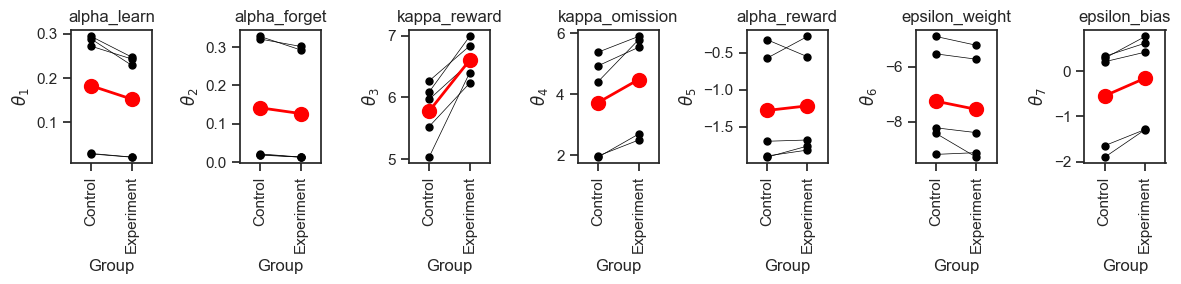

In [ ]:
# plot the parameters
fig, axes = plt.subplots(1, 7, figsize=(12, 3), sharex=True)
for i in range(7):
    # quantify the difference between the control and experiment groups using a non-parametric test
    _, p = stats.wilcoxon(params[:, 0, i], params[:, 1, i])
    print(f'{param_names[i]}: p = {p}')
    p = significance_stars(p)
    axes[i].plot(params[:, :, i].T, color='black', lw=0.5, marker='o', markersize=5)
    axes[i].plot([0, 1], params[:, :, i].mean(axis=0), color='red', lw=2, marker='o', markersize=10)
    axes[i].set_xlabel('Group')
    axes[i].set_ylabel(f'$\\theta_{i+1}$')
    axes[i].set_xticks([0,1], ['Control', 'Experiment'], rotation=90)
    axes[i].set_xlim(-0.5, 1.5)
    axes[i].set_title(f'{param_names[i]}')
    
plt.tight_layout()
plt.show()